<a href="https://colab.research.google.com/github/jems2019/AlternusVera/blob/socialCredibility/Social_Credibility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Library Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
import nltk.sentiment
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from scipy import sparse

#helper libraries to take metrics and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils.multiclass import unique_labels
from scipy.spatial.distance import cdist

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Helper function to print confusion matrix and other stats on each model

def model_stats(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.2)#for label size
    sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16},)# font size

    
    stats = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    print('\nprecision')
    print(stats[0])
    print('recall')
    print(stats[1])
    print('f1 score')
    print(stats[2])
    print('\n')
    

In [4]:
# url = 'https://raw.githubusercontent.com/jems2019/AlternusVera/socialCredibility/input_data/social_cred/'
# data_set = 'train_speaker_with_followers.csv'

# data = pd.read_csv(url+data_set)
# data.head()

# Reading in train_news with twitter info
train_twitter = '/content/drive/My Drive/train_news_twitter.csv'

# twitter = '/content/drive/My Drive/Speakers/cleaned/followers_tweets_verified.csv'
train_twitter = pd.read_csv(train_twitter, error_bad_lines=False).dropna().reset_index(drop=True)

#twitter['twitter_handle'] = '@' + twitter['twitter_handle'].astype(str)
train_twitter = train_twitter.drop(['Unnamed: 0'], axis=1)
train_twitter.head()


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers,tweets,verified
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,dwayne_bohac,2124.0,1230.0,0.0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,ssurovell,5969.0,8953.0,0.0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,BarackObama,106128237.0,15625.0,1.0
3,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",BarackObama,106128237.0,15625.0,1.0
4,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,SenStroebel,1400.0,1195.0,0.0


In [5]:
# url = 'https://raw.githubusercontent.com/jems2019/AlternusVera/socialCredibility/input_data/social_cred/'
# data_set = 'train_speaker_with_followers.csv'

# data = pd.read_csv(url+data_set)
# data.head()

# Reading in train_news with twitter info
test_twitter = '/content/drive/My Drive/test_news_twitter.csv'

# twitter = '/content/drive/My Drive/Speakers/cleaned/followers_tweets_verified.csv'
test_twitter = pd.read_csv(test_twitter, error_bad_lines=False).dropna().reset_index(drop=True)

#twitter['twitter_handle'] = '@' + twitter['twitter_handle'].astype(str)
test_twitter = test_twitter.drop(['Unnamed: 0'], axis=1)
test_twitter.head()


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers,tweets,verified
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,GovernorPerry,354084.0,3577.0,1.0
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,RepShankland,2652.0,2010.0,1.0
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,realDonaldTrump,60223138.0,41876.0,1.0
3,1046.json,barely-true,"Says Vice President Joe Biden ""admits that the...","economy,stimulus",john-boehner,Speaker of the House of Representatives,Ohio,republican,13,22,11,4,2,a press release.,SpeakerBoehner,1402319.0,22676.0,1.0
4,12849.json,true,Donald Trump is against marriage equality. He ...,"gays-and-lesbians,marriage",sean-patrick-maloney,Congressman for NY-18,New York,democrat,0,0,0,0,0,a speech at the Democratic National Convention,RepSeanMaloney,29396.0,5608.0,1.0


In [6]:
# url = 'https://raw.githubusercontent.com/jems2019/AlternusVera/socialCredibility/input_data/social_cred/'
# data_set = 'train_speaker_with_followers.csv'

# data = pd.read_csv(url+data_set)
# data.head()

# Reading in train_news with twitter info
valid_twitter = '/content/drive/My Drive/valid_news_twitter.csv'

# twitter = '/content/drive/My Drive/Speakers/cleaned/followers_tweets_verified.csv'
valid_twitter = pd.read_csv(valid_twitter, error_bad_lines=False).dropna().reset_index(drop=True)

#twitter['twitter_handle'] = '@' + twitter['twitter_handle'].astype(str)
valid_twitter = valid_twitter.drop(['Unnamed: 0'], axis=1)
valid_twitter.head()


,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers,tweets,verified
0,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,repblumenauer,62503.0,3907.0,1.0
1,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,JimFrancesconi,75.0,91.0,0.0
2,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,BarackObama,106128237.0,15625.0,1.0
3,9416.json,false,Says when armed civilians stop mass shootings ...,guns,jim-rubens,Small business owner,New Hampshire,republican,1,1,0,1,0,"in an interview at gun shop in Hudson, N.H.",JimRubens,829.0,1509.0,0.0
4,6861.json,true,Says Tennessee is providing millions of dollar...,"education,state-budget",andy-berke,Lawyer and state senator,Tennessee,democrat,0,0,0,0,0,a letter to state Senate education committee c...,AndyBerke,22643.0,8198.0,1.0


## Twitter Dataset Data Cleaning

In [0]:
class DataCleaning():
  
  # API to convert true, mostly-true and half-true to true
  # false, barely-true and pants-fire to false

  def convertMulticlassToBinaryclass(self, r):
    v = r['label'].lower()
    if (v == 'true'):
      return 6 #'true'
    if (v == 'mostly-true'):
      return 5 #'true'
    if (v == 'half-true'):
      return 4 #'true'
    if (v == 'barely-true'):
      return 3 #'false'
    if (v == 'false'):
      return 2 #'false'
    if (v == 'pants-fire'):
      return 1 #'false'
    
  def clean(self, twitter):
    data = twitter
    columnsToRemovePar = ['jsonid','speakerjobtitle']
    data = data.drop(columns=columnsToRemovePar)
        
    # convert the labels to true and false only
    data['label_bin'] = data.apply(self.convertMulticlassToBinaryclass, axis=1)
    return data
      
#   def __init__(self):  
#       global data
    # Remove unwanted columns in the dataset
     # data = pd.read_csv('https://raw.githubusercontent.com/jems2019/AlternusVera/socialCredibility/input_data/social_cred/train_speaker_with_followers.csv')

#       data = twitter
      
#       columnsToRemovePar = ['jsonid','speakerjobtitle']
#       data = data.drop(columns=columnsToRemovePar)
        
#     # convert the labels to true and false only
#       data['label'] = data.apply(self.convertMulticlassToBinaryclass, axis=1)

      
f= DataCleaning()

In [49]:
train_data = f.clean(train_twitter)
train_data.head(2)

,label,headline_text,subject,speaker,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers,tweets,verified,label_bin
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,dwayne_bohac,2124.0,1230.0,0.0,2
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,ssurovell,5969.0,8953.0,0.0,4


In [50]:
test_data = f.clean(test_twitter)
test_data.head(2)

,label,headline_text,subject,speaker,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers,tweets,verified,label_bin
0,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Texas,republican,30,30,42,23,18,Radio interview,GovernorPerry,354084.0,3577.0,1.0,6
1,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,Wisconsin,democrat,2,1,0,0,0,a news conference,RepShankland,2652.0,2010.0,1.0,2


In [51]:
valid_data = f.clean(valid_twitter)
valid_data.head(2)

,label,headline_text,subject,speaker,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context,twitter_handle,followers,tweets,verified,label_bin
0,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,repblumenauer,62503.0,3907.0,1.0,2
1,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Oregon,none,0,1,1,1,0,an opinion article,JimFrancesconi,75.0,91.0,0.0,4


# Determining Feature Importance

In [52]:
X = test_data[['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets', 'verified']]
y = test_data['label_bin']  # Labels
X_name = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets', 'verified']

# Split data into train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Below this is where the random forest model is set up and fed the data to classify on
# First training the modle using the data from the split of data above
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.32075471698113206


In [53]:
X = test_data[['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets']]
y = test_data['label_bin']  # Labels
X_name = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets']

# Split data into train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Below this is where the random forest model is set up and fed the data to classify on
# First training the modle using the data from the split of data above
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3113207547169811


In [58]:
X = train_data[['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets', 'verified']]
y = train_data['label_bin']  # Labels
X_name = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets', 'verified']

# Split data into train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Below this is where the random forest model is set up and fed the data to classify on
# First training the modle using the data from the split of data above
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3160779537149817


In [56]:
X = train_data[['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets']]
y = train_data['label_bin']  # Labels
X_name = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytrueocunts', 'pantsonfirecounts', 'followers', 'tweets']

# Split data into train and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Below this is where the random forest model is set up and fed the data to classify on
# First training the modle using the data from the split of data above
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.30572472594397077


No handles with labels found to put in legend.


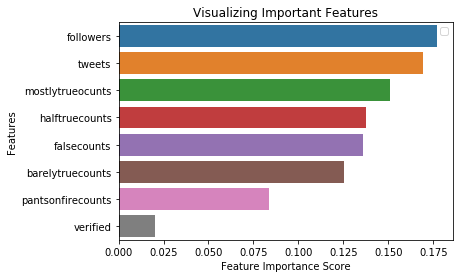

In [59]:
# Looking for feature importance
feature_imp = pd.Series(clf.feature_importances_,index=X_name).sort_values(ascending=False)
feature_imp

sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

No handles with labels found to put in legend.


Average accuracy for Gini criterion: 0.3172959805115712

Feature importance: 
followers            0.175984
tweets               0.168285
mostlytrueocunts     0.155910
halftruecounts       0.143710
falsecounts          0.127650
barelytruecounts     0.123794
pantsonfirecounts    0.084495
verified             0.020171
dtype: float64


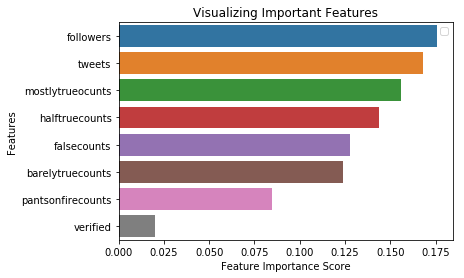


precision
0.3270151110064864
recall
0.31729598051157126
f1 score
0.3111010703796235


cross validation using 5:
[0.29927007 0.32390511 0.30136986 0.32387923 0.3010064 ]




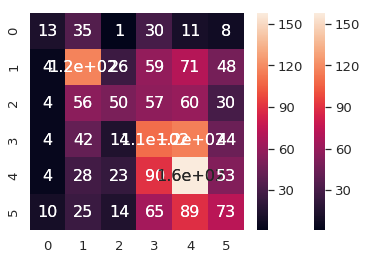

In [95]:
acc = 0
loop = 20
for i in range(loop):
  clf=RandomForestClassifier(n_estimators=100, random_state=10,)
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc += metrics.accuracy_score(y_test, y_pred)
  #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
tot_acc = acc/20
print ("Average accuracy for Gini criterion: " + str(tot_acc) + "\n")

feature_imp = pd.Series(clf.feature_importances_,index=X_name).sort_values(ascending=False)
print ("Feature importance: \n" + str(feature_imp))

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

conf_mat = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_mat, range(6), range(6))
conf_mat

sns.set(font_scale=1.2)#for label size
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 16})# font size

model_stats(y_test, y_pred)
print ("cross validation using 5:")
print(cross_val_score(clf, X ,y , cv = 5))
print("\n")

## Normalizing data

In [85]:
# Normalizing train_data
scaler = StandardScaler()
train_data['label_norm'] = scaler.fit_transform(train_data[['label']])
train_data['barelytruecounts_norm'] = scaler.fit_transform(train_data[['barelytruecounts']])
train_data['falsecounts_norm'] = scaler.fit_transform(train_data[['falsecounts']])
train_data['halftruecounts_norm'] = scaler.fit_transform(train_data[['halftruecounts']])
train_data['mostlytrueocunts_norm'] = scaler.fit_transform(train_data[['mostlytrueocunts']])
train_data['pantsonfirecounts_norm'] = scaler.fit_transform(train_data[['pantsonfirecounts']])
train_data['followers_norm'] = scaler.fit_transform(train_data[['followers']])
train_data['tweets_norm'] = scaler.fit_transform(train_data[['tweets']])



train_data_norm = train_data[['label_norm', 'speaker', 'headline_text', 'subject', 'stateinfo', 'partyaffiliation', 'barelytruecounts_norm', 'falsecounts_norm', 'halftruecounts_norm', 'mostlytrueocunts_norm',
                 'pantsonfirecounts_norm', 'twitter_handle', 'followers_norm', 'tweets_norm']]
train_data_norm.head()

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm
0,-1.406860,dwayne-bohac,Says the Annies List political group supports ...,abortion,Texas,republican,-0.805176,-0.677039,-0.643434,-0.611594,-0.525235,dwayne_bohac,-0.447824,-0.714300
1,0.055524,scott-surovell,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.805176,-0.710587,-0.621311,-0.589778,-0.525235,ssurovell,-0.447702,-0.153795
2,0.640478,barack-obama,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,2.213396,1.671336,2.896311,2.944464,0.147503,BarackObama,2.908789,0.330433
3,0.055524,barack-obama,I'm the only person on this stage who has work...,ethics,Illinois,democrat,2.213396,1.671336,2.896311,2.944464,0.147503,BarackObama,2.908789,0.330433
4,0.640478,duey-stroebel,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",Wisconsin,republican,-0.805176,-0.710587,-0.643434,-0.589778,-0.525235,SenStroebel,-0.447847,-0.716840


In [87]:
# Normalizing test_data
scaler = StandardScaler()
test_data['label_norm'] = scaler.fit_transform(test_data[['label']])
test_data['barelytruecounts_norm'] = scaler.fit_transform(test_data[['barelytruecounts']])
test_data['falsecounts_norm'] = scaler.fit_transform(test_data[['falsecounts']])
test_data['halftruecounts_norm'] = scaler.fit_transform(test_data[['halftruecounts']])
test_data['mostlytrueocunts_norm'] = scaler.fit_transform(test_data[['mostlytrueocunts']])
test_data['pantsonfirecounts_norm'] = scaler.fit_transform(test_data[['pantsonfirecounts']])
test_data['followers_norm'] = scaler.fit_transform(test_data[['followers']])
test_data['tweets_norm'] = scaler.fit_transform(test_data[['tweets']])


test_data_norm = test_data[['label_norm', 'speaker', 'headline_text', 'subject', 'stateinfo', 'partyaffiliation', 'barelytruecounts_norm', 'falsecounts_norm', 'halftruecounts_norm', 'mostlytrueocunts_norm',
                 'pantsonfirecounts_norm', 'twitter_handle', 'followers_norm', 'tweets_norm']]
test_data_norm.head()

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm
0,1.512313,rick-perry,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,0.520634,0.325802,0.313027,-0.093045,0.869430,GovernorPerry,-0.423741,-0.539530
1,-1.506319,katrina-shankland,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,-0.708857,-0.668677,-0.633630,-0.603960,-0.515764,RepShankland,-0.435078,-0.655226
2,-1.506319,donald-trump,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",New York,republican,1.969677,3.206362,0.515882,0.217946,4.178505,realDonaldTrump,1.507689,2.288203
3,-0.298866,john-boehner,"Says Vice President Joe Biden ""admits that the...","economy,stimulus",Ohio,republican,-0.225843,0.051463,-0.385696,-0.515105,-0.361853,SpeakerBoehner,-0.389924,0.870608
4,1.512313,sean-patrick-maloney,Donald Trump is against marriage equality. He ...,"gays-and-lesbians,marriage",New York,democrat,-0.796678,-0.702970,-0.633630,-0.603960,-0.515764,RepSeanMaloney,-0.434215,-0.389575


In [86]:
# Normalizing valid_data
scaler = StandardScaler()
valid_data['label_norm'] = scaler.fit_transform(valid_data[['label']])
valid_data['barelytruecounts_norm'] = scaler.fit_transform(valid_data[['barelytruecounts']])
valid_data['falsecounts_norm'] = scaler.fit_transform(valid_data[['falsecounts']])
valid_data['halftruecounts_norm'] = scaler.fit_transform(valid_data[['halftruecounts']])
valid_data['mostlytrueocunts_norm'] = scaler.fit_transform(valid_data[['mostlytrueocunts']])
valid_data['pantsonfirecounts_norm'] = scaler.fit_transform(valid_data[['pantsonfirecounts']])
valid_data['followers_norm'] = scaler.fit_transform(valid_data[['followers']])
valid_data['tweets_norm'] = scaler.fit_transform(valid_data[['tweets']])


valid_data_norm = valid_data[['label_norm', 'speaker', 'headline_text', 'subject', 'stateinfo', 'partyaffiliation', 'barelytruecounts_norm', 'falsecounts_norm', 'halftruecounts_norm', 'mostlytrueocunts_norm',
                 'pantsonfirecounts_norm', 'twitter_handle', 'followers_norm', 'tweets_norm']]
valid_data_norm.head()

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm
0,-1.375260,earl-blumenauer,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",Oregon,democrat,-0.818953,-0.683716,-0.623355,-0.593205,-0.529290,repblumenauer,-0.447347,-0.507596
1,0.123393,jim-francesconi,Says nearly half of Oregons children are poor.,poverty,Oregon,none,-0.818953,-0.683716,-0.623355,-0.593205,-0.529290,JimFrancesconi,-0.449325,-0.771011
2,0.123393,barack-obama,On attacks by Republicans that various program...,"economy,stimulus",Illinois,democrat,2.213702,1.646068,2.930332,2.972610,0.132899,BarackObama,2.913496,0.301289
3,-1.375260,jim-rubens,Says when armed civilians stop mass shootings ...,guns,New Hampshire,republican,-0.775629,-0.683716,-0.645705,-0.593205,-0.529290,JimRubens,-0.449301,-0.673128
4,1.622047,andy-berke,Says Tennessee is providing millions of dollar...,"education,state-budget",Tennessee,democrat,-0.818953,-0.716999,-0.645705,-0.615216,-0.529290,AndyBerke,-0.448610,-0.211391


In [0]:
# data['correlation_coeff'] = ((data[str(feature_imp.index[0])] * feature_imp[0])**4 + (data[str(feature_imp.index[1])] * feature_imp[1])**3 + (data[str(feature_imp.index[2])] * feature_imp[2])**2 + (data[str(feature_imp.index[3])] * feature_imp[3]))


# Data Cleaning and Text Preprocessing 

*Steps included in the preprocessing:*
- Remove Special Characters and Punctuations
- Lower case the news
- Tokenization
- Remove Stop Words
- Lemmatization
- Stemming 
- Spell Check 

In [0]:
import re

def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [225]:
import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# clean training and test data 
# create new column "tokenized"
# t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
test_data_norm['clean'] = test_data_norm["headline_text"].apply(cleaning) 
train_data_norm['clean'] = train_data_norm["headline_text"].apply(cleaning) 
valid_data_norm['clean'] = valid_data_norm["headline_text"].apply(cleaning) 

# t2 = time.time()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [0]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [0]:
def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

In [230]:
print("Before: \n", train_data_norm['clean'][0] )
t1 = time.time()
train_data_norm['clean'] = train_data_norm['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the train data: \n", len(train_data_norm), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",train_data_norm['clean'][0] )
train_data_norm.head(5)

Before: 
 say anni list polit group support third trimest abort demand

Time to spell check the train data: 
 5473 news: 2.615685812632243 min

After: 
 say anni list polit group support third trimmest abort demand


,Unnamed: 0,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector,label_bin
0,0,-1.406860,dwayne-bohac,Says the Annies List political group supports ...,abortion,Texas,republican,-0.805176,-0.677039,-0.643434,-0.611594,-0.525235,dwayne_bohac,-0.447824,-0.714300,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.2960,0,1,0.549989,support obama american never would trump educ ...,"[-0.714299885242439, -1.4068599484645308, 0.29...",2
1,1,0.055524,scott-surovell,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.805176,-0.710587,-0.621311,-0.589778,-0.525235,ssurovell,-0.447702,-0.153795,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,1,2,0.366663,administr year govern peopl time obama offic n...,"[-0.15379478352627304, 0.055524101134036455, 0...",4
2,2,0.640478,barack-obama,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,2.213396,1.671336,2.896311,2.944464,0.147503,BarackObama,2.908789,0.330433,hillary clinton agre john mccain vote give geo...,"[0.161, 0.645, 0.194, 0.128]",0,0.1280,2,8,0.549984,vote world take year time state candid spend r...,"[0.33043285322761273, 0.6404777209734632, 0.12...",5
3,3,0.055524,barack-obama,I'm the only person on this stage who has work...,ethics,Illinois,democrat,2.213396,1.671336,2.896311,2.944464,0.147503,BarackObama,2.908789,0.330433,person stage work activ last year pass along r...,"[0.085, 0.915, 0.0, -0.0772]",0,-0.0772,3,5,0.819978,year state last highest american percent citi ...,"[0.33043285322761273, 0.055524101134036455, -0...",4
4,4,0.640478,duey-stroebel,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",Wisconsin,republican,-0.805176,-0.710587,-0.643434,-0.589778,-0.525235,SenStroebel,-0.447847,-0.716840,say gop primary ippon glenn gaothan joe leibha...,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,4,6,0.666496,health care plan fund immigra american cost go...,"[-0.7168400482050269, 0.6404777209734632, 0.0,...",5


In [0]:
# saving data to csv
train_data_norm.to_csv('train_data_normalized.csv')
!cp train_data_normalized.csv drive/My\ Drive/

In [97]:
print("Before: \n", test_data_norm['clean'][0] )
t1 = time.time()
test_data_norm['clean'] = test_data_norm['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the test data: \n", len(test_data_norm), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",test_data_norm['clean'][0] )
test_data_norm.head(5)

Before: 
 build wall u mexico border take liter year

Time to spell check the train data: 
 705 news: 0.33019599119822185 min

After: 
 build wall u mexico border take liter year


,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean
0,1.512313,rick-perry,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,0.520634,0.325802,0.313027,-0.093045,0.869430,GovernorPerry,-0.423741,-0.539530,build wall u mexico border take liter year
1,-1.506319,katrina-shankland,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,-0.708857,-0.668677,-0.633630,-0.603960,-0.515764,RepShankland,-0.435078,-0.655226,wisconsin pace doubl number layoff year
2,-1.506319,donald-trump,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",New York,republican,1.969677,3.206362,0.515882,0.217946,4.178505,realDonaldTrump,1.507689,2.288203,say john mccain done noth help vet
3,-0.298866,john-boehner,"Says Vice President Joe Biden ""admits that the...","economy,stimulus",Ohio,republican,-0.225843,0.051463,-0.385696,-0.515105,-0.361853,SpeakerBoehner,-0.389924,0.870608,say vice presid joe biden admit american peopl...
4,1.512313,sean-patrick-maloney,Donald Trump is against marriage equality. He ...,"gays-and-lesbians,marriage",New York,democrat,-0.796678,-0.702970,-0.633630,-0.603960,-0.515764,RepSeanMaloney,-0.434215,-0.389575,donald trump marriage equal want go back


In [0]:
# saving data to csv
test_data_norm.to_csv('test_data_normalized.csv')
!cp test_data_normalized.csv drive/My\ Drive/

In [98]:
print("Before: \n", valid_data_norm['clean'][0] )
t1 = time.time()
valid_data_norm['clean'] = valid_data_norm['clean'].apply(spell_checker)
t2 = time.time()
print("\nTime to spell check the valid data: \n", len(valid_data_norm), "news:", (t2-t1)/60, "min")

print("\nAfter: \n",valid_data_norm['clean'][0] )
valid_data_norm.head(5)

Before: 
 say organ parad social welfar organ involv polit combat harken back statut hundr year ago said prohibit

Time to spell check the valid data: 
 702 news: 0.3427718997001648 min

After: 
 say organ parade social welfare organ involv polit combat harken back statut hundi year ago said prohibit


,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean
0,-1.375260,earl-blumenauer,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",Oregon,democrat,-0.818953,-0.683716,-0.623355,-0.593205,-0.529290,repblumenauer,-0.447347,-0.507596,say organ parade social welfare organ involv p...
1,0.123393,jim-francesconi,Says nearly half of Oregons children are poor.,poverty,Oregon,none,-0.818953,-0.683716,-0.623355,-0.593205,-0.529290,JimFrancesconi,-0.449325,-0.771011,say near half oregon child poor
2,0.123393,barack-obama,On attacks by Republicans that various program...,"economy,stimulus",Illinois,democrat,2.213702,1.646068,2.930332,2.972610,0.132899,BarackObama,2.913496,0.301289,attack republican various program econom stimu...
3,-1.375260,jim-rubens,Says when armed civilians stop mass shootings ...,guns,New Hampshire,republican,-0.775629,-0.683716,-0.645705,-0.593205,-0.529290,JimRubens,-0.449301,-0.673128,say arm civilian stop mass shoot gun averag pe...
4,1.622047,andy-berke,Says Tennessee is providing millions of dollar...,"education,state-budget",Tennessee,democrat,-0.818953,-0.716999,-0.645705,-0.615216,-0.529290,AndyBerke,-0.448610,-0.211391,say tennessee provid million dollar virtual sc...


In [0]:
# saving data to csv
valid_data_norm.to_csv('valid_data_normalized.csv')
!cp valid_data_normalized.csv drive/My\ Drive/

# Sentiment Analysis

In [175]:
# Using sentiment analysis to get sentiment score

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))
    
print_sentiment_scores(train_data_norm['clean'][0])
print_sentiment_scores(test_data_norm['clean'][0])
print_sentiment_scores(valid_data_norm['clean'][0])

say anni list polit group support third trimmest abort demand 
{'neg': 0.123, 'neu': 0.656, 'pos': 0.221, 'compound': 0.296}
build wall u mexico border take liter year 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
say organ parade social welfare organ involv polit combat harken back statut hundi year ago said prohibit 
{'neg': 0.13, 'neu': 0.87, 'pos': 0.0, 'compound': -0.34}


In [0]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [0]:
#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

In [106]:
sentiment = []
vader_pol = []
cmp_score = []
for row in train_data_norm['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
train_data_norm['sentiment_vector'] = sentiment
train_data_norm['vader_polarity'] = vader_pol
train_data_norm['sentiment_score'] = cmp_score
    

   

[0, 0.123, 0.656, 0.221, 0.296]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.161, 0.645, 0.194, 0.128]
[0, 0.085, 0.915, 0.0, -0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.667, 0.333, 0.6124]
[0, 0.32, 0.68, 0.0, -0.5106]
[0, 0.153, 0.657, 0.19, 0.128]
[0, 0.2, 0.522, 0.278, 0.2263]
[0, 0.108, 0.773, 0.119, 0.0516]
[0, 0.198, 0.802, 0.0, -0.4939]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.543, 0.457, 0.6369]
[0, 0.0, 1.0, 0.0, 0.0]
[-1, 0.507, 0.493, 0.0, -0.802]
[0, 0.0, 0.859, 0.141, 0.2411]
[0, 0.238, 0.495, 0.267, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.199, 0.588, 0.213, 0.0516]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.184, 0.702, 0.114, -0.2033]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.333, 0.667, 0.0, -0.6124]
[0, 0.0, 0.735, 0.265, 0.5574]
[0, 0.415, 0.585, 0.0, -0.8316]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.087, 0.73, 0.183, 0.2924]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.116, 0.884, 0.0, -0.2732]
[0, 0.0, 1.0, 0.0, 0.0]
[0,

In [107]:
sentiment = []
vader_pol = []
cmp_score = []
for row in test_data_norm['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    
  
test_data_norm['sentiment_vector'] = sentiment
test_data_norm['vader_polarity'] = vader_pol
test_data_norm['sentiment_score'] = cmp_score

[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.794, 0.206, 0.0772]
[0, 0.0, 0.69, 0.31, 0.4019]
[0, 0.239, 0.645, 0.116, -0.4404]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.286, 0.714, 0.0, -0.34]
[0, 0.195, 0.805, 0.0, -0.5267]
[0, 0.351, 0.36, 0.288, -0.1779]
[0, 0.0, 0.657, 0.343, 0.5719]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.822, 0.178, 0.0772]
[0, 0.0, 0.737, 0.263, 0.3612]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.921, 0.079, 0.0516]
[0, 0.0, 0.735, 0.265, 0.5574]
[0, 0.296, 0.704, 0.0, -0.2732]
[0, 0.179, 0.536, 0.286, 0.296]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.652, 0.348, 0.4939]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.789, 0.211, 0.4939]
[0, 0.0, 0.515, 0.485, 0.9432]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.872, 0.128, 0.2263]
[0, 0.0, 0.777, 0.223, 0.5106]
[0, 0.0, 0.755, 0.245, 0.3818]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.524, 0.476, 0.8442]
[0, 0.25

In [108]:
sentiment = []
vader_pol = []
cmp_score = []
for row in valid_data_norm['clean']:
    get_pols = get_polarity_type(row)
    sentiment.append(get_pols[1:])
    vader_pol.append(get_pols[0])
    cmp_score.append(get_pols[1:][-1]) #last element 
    

valid_data_norm['sentiment_vector'] = sentiment
valid_data_norm['vader_polarity'] = vader_pol
valid_data_norm['sentiment_score'] = cmp_score

[0, 0.13, 0.87, 0.0, -0.34]
[0, 0.383, 0.617, 0.0, -0.4767]
[0, 0.181, 0.819, 0.0, -0.4767]
[-1, 0.622, 0.378, 0.0, -0.93]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.162, 0.838, 0.0, -0.4019]
[0, 0.211, 0.789, 0.0, -0.1531]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.802, 0.198, 0.6369]
[0, 0.209, 0.791, 0.0, -0.4404]
[0, 0.306, 0.694, 0.0, -0.296]
[0, 0.346, 0.654, 0.0, -0.5719]
[0, 0.213, 0.551, 0.236, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.776, 0.224, 0.3818]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.196, 0.804, 0.0, -0.296]
[0, 0.306, 0.484, 0.21, -0.5267]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.61, 0.39, 0.4939]
[0, 0.199, 0.641, 0.16, -0.1531]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.706, 0.294, 0.3612]
[0, 0.0, 0.902, 0.098, 0.0772]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.0, 0.859, 0.141, 0.3182]
[0, 0.133, 0.867, 0.0, -0.3818]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.138, 0.724, 0.138, 0.0]
[0, 0.0, 1.0, 0.0, 0.0]
[0, 0.333, 0.667, 0.0, -0.3612]
[0, 0.113, 0.755, 0.132, 0.1027]
[0, 0.0, 0.52

In [109]:
train_data_norm.head(2)

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score
0,-1.406860,dwayne-bohac,Says the Annies List political group supports ...,abortion,Texas,republican,-0.805176,-0.677039,-0.643434,-0.611594,-0.525235,dwayne_bohac,-0.447824,-0.714300,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.296
1,0.055524,scott-surovell,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.805176,-0.710587,-0.621311,-0.589778,-0.525235,ssurovell,-0.447702,-0.153795,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.000


In [111]:
test_data_norm.head(2)

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score
0,1.512313,rick-perry,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,0.520634,0.325802,0.313027,-0.093045,0.869430,GovernorPerry,-0.423741,-0.539530,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000
1,-1.506319,katrina-shankland,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,-0.708857,-0.668677,-0.633630,-0.603960,-0.515764,RepShankland,-0.435078,-0.655226,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772


In [112]:
valid_data_norm.head(2)

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score
0,-1.375260,earl-blumenauer,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",Oregon,democrat,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,repblumenauer,-0.447347,-0.507596,say organ parade social welfare organ involv p...,"[0.13, 0.87, 0.0, -0.34]",0,-0.3400
1,0.123393,jim-francesconi,Says nearly half of Oregons children are poor.,poverty,Oregon,none,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,JimFrancesconi,-0.449325,-0.771011,say near half oregon child poor,"[0.383, 0.617, 0.0, -0.4767]",0,-0.4767


In [0]:
# saving data to csv
test_data_norm.to_csv('test_data_norm_sentiment.csv')
!cp test_data_norm_sentiment.csv drive/My\ Drive/

In [0]:
# saving data to csv
valid_data_norm.to_csv('valid_data_norm_sentiment.csv')
!cp valid_data_norm_sentiment.csv drive/My\ Drive/

In [0]:
# saving data to csv
train_data_norm.to_csv('train_data_norm_sentiment.csv')
!cp train_data_norm_sentiment.csv drive/My\ Drive/

# Topic Modeling

In [0]:
train_filename = '/content/drive/My Drive/train_data_norm_sentiment.csv'

train_data_norm = pd.read_csv(train_filename, error_bad_lines=False)

In [216]:
train_data_norm['index'] = train_data_norm.index
train_lda = train_data_norm[['clean', 'index']]
train_lda.head(4)

,clean,index
0,say anni list polit group support third trimme...,0
1,decline coal start start natur gas took start ...,1
2,hillary clinton agre john mccain vote give geo...,2
3,person stage work activ last year pass along r...,3


In [0]:
test_filename = '/content/drive/My Drive/test_data_norm_sentiment.csv'

test_data_norm = pd.read_csv(test_filename, error_bad_lines=False)

In [219]:
test_data_norm['index'] = test_data_norm.index
test_lda = test_data_norm[['clean', 'index']]
test_lda.head(4)

,clean,index
0,build wall u mexico border take liter year,0
1,wisconsin pace doubl number layoff year,1
2,say john mccain done noth help vet,2
3,say vice presid joe biden admit american peopl...,3


In [0]:
valid_filename = '/content/drive/My Drive/valid_data_norm_sentiment.csv'

valid_data_norm = pd.read_csv(valid_filename, error_bad_lines=False)

In [17]:
valid_data_norm['index'] = valid_data_norm.index
valid_lda = valid_data_norm[['clean', 'index']]
valid_lda.head(4)

,clean,index
0,say organ parade social welfare organ involv p...,0
1,say near half oregon child poor,1
2,attack republican various program econom stimu...,2
3,say arm civilian stop mass shoot gun averag pe...,3


In [221]:
train_processed_docs = train_lda['clean'].map(lambda doc: doc.split(" "))
train_processed_docs[:4]

0    [say, anni, list, polit, group, support, third...
1    [decline, coal, start, start, natur, gas, took...
2    [hillary, clinton, agre, john, mccain, vote, g...
3    [person, stage, work, activ, last, year, pass,...
Name: clean, dtype: object

In [220]:
test_processed_docs = test_lda['clean'].map(lambda doc: doc.split(" "))
test_processed_docs[:4]

0    [build, wall, u, mexico, border, take, liter, ...
1       [wisconsin, pace, doubl, number, layoff, year]
2           [say, john, mccain, done, noth, help, vet]
3    [say, vice, presid, joe, biden, admit, america...
Name: clean, dtype: object

In [29]:
valid_processed_docs = valid_lda['clean'].map(lambda doc: doc.split(" "))
valid_processed_docs[:4]

0    [say, organ, parade, social, welfare, organ, i...
1               [say, near, half, oregon, child, poor]
2    [attack, republican, various, program, econom,...
3    [say, arm, civilian, stop, mass, shoot, gun, a...
Name: clean, dtype: object

In [0]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

In [0]:
def get_dictionary_print_words(dataframe,colname,processed_docs):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim#, tokenized_docs_local

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
train_tokenized_docs_local = train_data_norm['clean'].map(get_word_tokens)
test_tokenized_docs_local = test_data_norm['clean'].map(get_word_tokens)
valid_tokenized_docs_local = valid_data_norm['clean'].map(get_word_tokens)

In [0]:
def get_bow_corpus_print_sample(dataframe,colname,processed_docs,tokenized_docs_local):
#     dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname, processed_docs)
    dictionary_gensim = get_dictionary_print_words(dataframe, colname, processed_docs)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

In [242]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(train_data_norm,'clean',train_processed_docs,train_tokenized_docs_local)

######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 third
9 trimmest
10 administr

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (6, 1)]

 ######## PREVIEW BOW ########
Word 0 ("abort") appears 1 time.
Word 1 ("group") appears 1 time.
Word 2 ("list") appears 1 time.
Word 3 ("polit") appears 1 time.
Word 5 ("support") appears 1 time.
Word 6 ("third") appears 1 time.


In [44]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(test_data_norm,'clean',test_processed_docs,test_tokenized_docs_local)

######## DICTIONARY Words and occurences ########
0 border
1 build
2 liter
3 mexico
4 take
5 u
6 wall
7 year
8 doubl
9 layoff
10 number

 ######## BOW VECTOR FIRST ITEM ########
[(1, 1)]

 ######## PREVIEW BOW ########
Word 1 ("year") appears 1 time.


In [47]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(valid_data_norm,'clean',valid_processed_docs,valid_tokenized_docs_local)

######## DICTIONARY Words and occurences ########
0 ago
1 back
2 combat
3 harken
4 hundi
5 involv
6 organ
7 parade
8 polit
9 prohibit
10 said

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (2, 1)]

 ######## PREVIEW BOW ########
Word 0 ("said") appears 1 time.
Word 2 ("year") appears 1 time.


In [0]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

In [246]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['state', 'year', 'percent', 'text', 'every', 'spend', 'unit', 'wisconsin', 'presid', 'increas']
1::['vote', 'health', 'plan', 'care', 'peopl', 'fund', 'iller', 'insur', 'even', 'immigra']
2::['care', 'health', 'obama', 'presid', 'govern', 'barack', 'country', 'feder', 'million', 'said']
3::['year', 'million', 'peopl', 'american', 'would', 'make', 'averag', 'famili', 'percent', 'time']
4::['state', 'percent', 'million', 'would', 'year', 'nation', 'county', 'rais', 'said', 'creat']
5::['billion', 'vote', 'republican', 'want', 'year', 'democrat', 'medical', 'million', 'america', 'state']
6::['year', 'state', 'last', 'clinton', 'percent', 'hillary', 'billion', 'school', 'budget', 'district']
7::['percent', 'state', 'nation', 'feder', 'increas', 'year', 'unit', 'incom', 'america', 'right']
8::['obama', 'presid', 'year', 'time', 'peopl', 'support', 'percent', 'barack', 'offic', 'trump']
9::['percent', 'rate', 'state', 'obama', 'billion', 'work', 'american', 'john', 'presid', 'peopl']


In [0]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

In [60]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
train_data_norm = update_lda_results_to_dataset(
    train_data_norm, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)

train_data_norm.head(2)

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,-1.406860,dwayne-bohac,Says the Annies List political group supports ...,abortion,Texas,republican,-0.805176,-0.677039,-0.643434,-0.611594,-0.525235,dwayne_bohac,-0.447824,-0.714300,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.296,0,1,0.549989,support obama american never would trump educ ...
1,0.055524,scott-surovell,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.805176,-0.710587,-0.621311,-0.589778,-0.525235,ssurovell,-0.447702,-0.153795,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.000,1,2,0.366663,administr year govern peopl time obama offic n...


In [61]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
test_data_norm = update_lda_results_to_dataset(
    test_data_norm, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)
test_data_norm = test_data_norm.drop(columns="Unnamed: 0")
test_data_norm.head(2)

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,1.512313,rick-perry,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,0.520634,0.325802,0.313027,-0.093045,0.869430,GovernorPerry,-0.423741,-0.539530,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,0,8,0.699956,vote world take year time state candid spend r...
1,-1.506319,katrina-shankland,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,-0.708857,-0.668677,-0.633630,-0.603960,-0.515764,RepShankland,-0.435078,-0.655226,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772,1,5,0.699972,year state last highest american percent citi ...


In [62]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
valid_data_norm = update_lda_results_to_dataset(
    valid_data_norm, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)
valid_data_norm = valid_data_norm.drop(columns="Unnamed: 0")
valid_data_norm.head(2)

,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words
0,-1.375260,earl-blumenauer,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",Oregon,democrat,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,repblumenauer,-0.447347,-0.507596,say organ parade social welfare organ involv p...,"[0.13, 0.87, 0.0, -0.34]",0,-0.3400,0,0,0.371841,percent want said republican increas company w...
1,0.123393,jim-francesconi,Says nearly half of Oregons children are poor.,poverty,Oregon,none,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,JimFrancesconi,-0.449325,-0.771011,say near half oregon child poor,"[0.383, 0.617, 0.0, -0.4767]",0,-0.4767,1,3,0.549980,presid peopl every obama america half offic ba...


In [0]:
# saving data to csv
test_data_norm.to_csv('test_data_norm_topic.csv')
!cp test_data_norm_topic.csv drive/My\ Drive/

In [0]:
# saving data to csv
train_data_norm.to_csv('train_data_norm_topic.csv')
!cp train_data_norm_topic.csv drive/My\ Drive/

In [0]:
# saving data to csv
valid_data_norm.to_csv('valid_data_norm_topic.csv')
!cp valid_data_norm_topic.csv drive/My\ Drive/

# Social Credibility

In [0]:
test_data_norm = pd.read_csv('/content/drive/My Drive/test_data_norm_credibility.csv')
train_data_norm = pd.read_csv('/content/drive/My Drive/train_data_norm_credibility.csv')
valid_data_norm = pd.read_csv('/content/drive/My Drive/valid_data_norm_credibility.csv')


In [0]:
def credibility(data):
  credibility = []  
  l=[]
  for i ,j in data.iterrows():

   
    index = int(i)
    v = np.array(data.iloc[index]['followers_norm'])
    v = np.array(data.iloc[index]['tweets_norm'])
    v = np.append(v, data.iloc[index]['label_norm'])
    v = np.append(v, data.iloc[index]['sentiment_score'])
    v = np.append(v, data.iloc[index]['lda_score'])

    l.append(v)

  print(l) 

  return l




In [64]:
test_data_norm['cred_vector'] = credibility(test_data_norm)
train_data_norm['cred_vector'] = credibility(train_data_norm)
valid_data_norm['cred_vector'] = credibility(valid_data_norm)

[array([-0.53952955,  1.51231336,  0.        ,  0.69995588]), array([-0.65522597, -1.50631891,  0.0772    ,  0.69997203]), array([ 2.28820319, -1.50631891,  0.4019    ,  0.1       ]), array([ 0.87060825, -0.298866  , -0.4404    ,  0.502859  ]), array([-0.38957459,  1.51231336,  0.0772    ,  0.69995928]), array([-0.38470161, -0.298866  ,  0.        ,  0.69997495]), array([-0.55112135,  0.00299722,  0.        ,  0.1       ]), array([-0.63440505, -1.50631891, -0.34      ,  0.54996955]), array([-0.37591547,  0.00299722, -0.5267    ,  0.43597516]), array([ 0.00151918,  1.51231336, -0.1779    ,  0.55457717]), array([-0.46429366,  0.60672368,  0.5719    ,  0.69994187]), array([0.00809032, 0.00299722, 0.        , 0.77494758]), array([ 2.28820319, -1.50631891,  0.0772    ,  0.7749815 ]), array([-0.10243778,  1.51231336,  0.3612    ,  0.69997311]), array([ 0.00151918, -0.298866  ,  0.        ,  0.1       ]), array([-0.38470161,  1.51231336,  0.0516    ,  0.68293971]), array([-0.46835448, -1.5063

In [73]:
test_data_norm['label_bin'] = test_data['label_bin']
# test_data_norm = test_data_norm.drop(columns="label_norm")


# # saving data to csv
test_data_norm.to_csv('test_data_norm_credibility.csv')
!cp test_data_norm_credibility.csv drive/My\ Drive/

test_data_norm.head(2)


,Unnamed: 0,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector,label_bin
0,0,rick-perry,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,0.520634,0.325802,0.313027,-0.093045,0.869430,GovernorPerry,-0.423741,-0.539530,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0000,0,8,0.699956,vote world take year time state candid spend r...,"[-0.5395295545107555, 1.5123133596003209, 0.0,...",6
1,1,katrina-shankland,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,-0.708857,-0.668677,-0.633630,-0.603960,-0.515764,RepShankland,-0.435078,-0.655226,wisconsin pace doubl number layoff year,"[0.0, 0.794, 0.206, 0.0772]",0,0.0772,1,5,0.699972,year state last highest american percent citi ...,"[-0.6552259748621244, -1.5063189125350875, 0.0...",2


In [74]:
train_data_norm['label_bin'] = train_data['label_bin']
# test_data_norm = test_data_norm.drop(columns="label_norm")


# # saving data to csv
train_data_norm.to_csv('train_data_norm_credibility.csv')
!cp train_data_norm_credibility.csv drive/My\ Drive/

train_data_norm.head(2)

,Unnamed: 0,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector,label_bin
0,0,-1.406860,dwayne-bohac,Says the Annies List political group supports ...,abortion,Texas,republican,-0.805176,-0.677039,-0.643434,-0.611594,-0.525235,dwayne_bohac,-0.447824,-0.714300,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.296,0,1,0.549989,support obama american never would trump educ ...,"[-0.714299885242439, -1.4068599484645308, 0.29...",2
1,1,0.055524,scott-surovell,When did the decline of coal start? It started...,"energy,history,job-accomplishments",Virginia,democrat,-0.805176,-0.710587,-0.621311,-0.589778,-0.525235,ssurovell,-0.447702,-0.153795,decline coal start start natur gas took start ...,"[0.0, 1.0, 0.0, 0.0]",0,0.000,1,2,0.366663,administr year govern peopl time obama offic n...,"[-0.15379478352627304, 0.055524101134036455, 0...",4


In [77]:
valid_data_norm['label_bin'] = valid_data['label_bin']
# test_data_norm = test_data_norm.drop(columns="label_norm")


# # saving data to csv
valid_data_norm.to_csv('valid_data_norm_credibility.csv')
!cp valid_data_norm_credibility.csv drive/My\ Drive/

valid_data_norm.head(2)

,Unnamed: 0,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector,label_bin
0,0,-1.375260,earl-blumenauer,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",Oregon,democrat,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,repblumenauer,-0.447347,-0.507596,say organ parade social welfare organ involv p...,"[0.13, 0.87, 0.0, -0.34]",0,-0.3400,0,0,0.371841,percent want said republican increas company w...,"[-0.5075955931703962, -1.3752599392148286, -0....",2
1,1,0.123393,jim-francesconi,Says nearly half of Oregons children are poor.,poverty,Oregon,none,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,JimFrancesconi,-0.449325,-0.771011,say near half oregon child poor,"[0.383, 0.617, 0.0, -0.4767]",0,-0.4767,1,3,0.549980,presid peopl every obama america half offic ba...,"[-0.771011015620636, 0.12339339411148242, -0.4...",4


In [0]:
# # saving data to csv
# train_data_norm.to_csv('train_data_norm_credibility.csv')
# !cp train_data_norm_credibility.csv drive/My\ Drive/


In [0]:
# # saving data to csv
# test_data_norm.to_csv('test_data_norm_credibility.csv')
# !cp test_data_norm_credibility.csv drive/My\ Drive/

In [0]:
# # saving data to csv
# valid_data_norm.to_csv('valid_data_norm_credibility.csv')
# !cp valid_data_norm_credibility.csv drive/My\ Drive/

In [22]:
test_data_norm = pd.read_csv('/content/drive/My Drive/test_data_norm_credibility.csv')
test_data_norm.head(1)

,Unnamed: 0,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector
0,0,1.512313,rick-perry,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,0.520634,0.325802,0.313027,-0.093045,0.86943,GovernorPerry,-0.423741,-0.53953,build wall u mexico border take liter year,"[0.0, 1.0, 0.0, 0.0]",0,0.0,0,8,0.699956,vote world take year time state candid spend r...,[-0.53952955 1.51231336 0. 0.69995588]


In [24]:
train_data_norm = pd.read_csv('/content/drive/My Drive/train_data_norm_credibility.csv')
train_data_norm.head(1)

,Unnamed: 0,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector
0,0,-1.40686,dwayne-bohac,Says the Annies List political group supports ...,abortion,Texas,republican,-0.805176,-0.677039,-0.643434,-0.611594,-0.525235,dwayne_bohac,-0.447824,-0.7143,say anni list polit group support third trimme...,"[0.123, 0.656, 0.221, 0.296]",0,0.296,0,1,0.549989,support obama american never would trump educ ...,[-0.71429989 -1.40685995 0.296 0.54998857]


In [25]:
valid_data_norm = pd.read_csv('/content/drive/My Drive/valid_data_norm_credibility.csv')
valid_data_norm.head(1)

,Unnamed: 0,label_norm,speaker,headline_text,subject,stateinfo,partyaffiliation,barelytruecounts_norm,falsecounts_norm,halftruecounts_norm,mostlytrueocunts_norm,pantsonfirecounts_norm,twitter_handle,followers_norm,tweets_norm,clean,sentiment_vector,vader_polarity,sentiment_score,index,topic_number,lda_score,topic_top_words,cred_vector
0,0,-1.37526,earl-blumenauer,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",Oregon,democrat,-0.818953,-0.683716,-0.623355,-0.593205,-0.52929,repblumenauer,-0.447347,-0.507596,say organ parade social welfare organ involv p...,"[0.13, 0.87, 0.0, -0.34]",0,-0.34,0,0,0.371841,percent want said republican increas company w...,[-0.50759559 -1.37525994 -0.34 0.3718414 ]


In [155]:
train_sentiment = train_data_norm.loc[:,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]
train_sentiment.head(2)

,followers_norm,tweets_norm,sentiment_score,lda_score
0,-0.447824,-0.714300,0.296,0.549989
1,-0.447702,-0.153795,0.000,0.366663


In [156]:
test_sentiment = test_data_norm.loc[:,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]
test_sentiment.head(2)

,followers_norm,tweets_norm,sentiment_score,lda_score
0,-0.423741,-0.539530,0.0000,0.699956
1,-0.435078,-0.655226,0.0772,0.699972


In [157]:
train = train_data_norm.loc[1,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]
train

followers_norm    -0.447702
tweets_norm       -0.153795
sentiment_score           0
lda_score          0.366663
Name: 1, dtype: object

In [158]:
test = test_data_norm.loc[1,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]
test

followers_norm    -0.435078
tweets_norm       -0.655226
sentiment_score      0.0772
lda_score          0.699972
Name: 1, dtype: object

In [160]:
test_sentiment.head(4)

,followers_norm,tweets_norm,sentiment_score,lda_score
0,-0.423741,-0.539530,0.0000,0.699956
1,-0.435078,-0.655226,0.0772,0.699972
2,1.507689,2.288203,0.4019,0.100000
3,-0.389924,0.870608,-0.4404,0.502859


In [159]:
train_sentiment.head(4)

,followers_norm,tweets_norm,sentiment_score,lda_score
0,-0.447824,-0.714300,0.2960,0.549989
1,-0.447702,-0.153795,0.0000,0.366663
2,2.908789,0.330433,0.1280,0.549984
3,2.908789,0.330433,-0.0772,0.819978


In [162]:

for i in range(10):
  index = int(i)
  print(cosine_similarity([train_data_norm.iloc[1]['cred_vector']], [train_data_norm.iloc[index]['cred_vector']] ))


[[0.34259932]]
[[1.]]
[[0.50711667]]
[[0.70852323]]
[[0.83086853]]
[[0.63625559]]
[[0.40712906]]
[[0.28554687]]
[[0.76868452]]
[[0.15091825]]


In [161]:
# find closest document in training dataset
dist = cdist([train], train_sentiment, metric='cosine')
sim_index = dist.argmin() # getting smallest cosine index
sim_dist = dist[0, dist.argmin()]

# getting the closest doc
predicted = train_data_norm.loc[sim_index, 'label_bin']
predicted_prob = 1-sim_dist

print("Predicted: ", predicted, " Probability: ", predicted_prob)

Predicted:  4  Probability:  1.0


In [163]:
# find closest document in training dataset
dist = cdist([test], test_sentiment, metric='cosine')
sim_index = dist.argmin() # getting smallest cosine index
sim_dist = dist[0, dist.argmin()]

# getting the closest doc
predicted = test_data_norm.loc[sim_index, 'label_bin']
predicted_prob = 1-sim_dist

print("Predicted: ", predicted, " Probability: ", predicted_prob)

Predicted:  2  Probability:  1.0


In [0]:
# train,test = train_test_split(data_norm, test_size=0.2)
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

test = test_data_norm
train = train_data_norm

In [185]:
train_set = train.loc[:,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]

test_set = test.loc[:,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]



# find closest document in training dataset
dist = cdist(test_set, train_set, metric='cosine')

dist


array([[0.06634566, 0.09801757, 1.35107655, ..., 1.24981095, 0.14431277,
        0.23933269],
       [0.03339336, 0.1264387 , 1.34541018, ..., 1.27683992, 0.18575188,
        0.23646391],
       [1.7344668 , 1.59673614, 0.36484948, ..., 0.42418164, 1.64961415,
        1.9484822 ],
       ...,
       [1.09959222, 0.93491222, 0.61998862, ..., 1.4733819 , 0.3960685 ,
        0.90156761],
       [0.48210344, 0.1603016 , 1.31595868, ..., 0.62192233, 0.41285175,
        0.66911201],
       [0.577418  , 0.18041775, 1.87295266, ..., 0.57309844, 0.60004287,
        0.43063978]])

In [186]:
predict = pd.DataFrame()
c = 0

# all indexes and distance for each test/train set
for row in dist:
  predict.loc[c,'index'] = row.argmin()
  predict.loc[c,'dist'] = row[row.argmin()]
  c+=1


for index, row in predict.iterrows():
  predict.loc[index, 'prediction'] = train.loc[row['index'],'label_bin']
  
  
score = metrics.accuracy_score(test['label_bin'], predict['prediction'])

print("Score: %0.6f" % score)


Score: 0.173050


In [0]:

dist = cdist(input, train_set, metric='cosine')

predict = pd.DataFrame()
c = 0

# all indexes and distance for each test/train set
for row in dist:
  predict.loc[c,'index'] = row.argmin()
  predict.loc[c,'dist'] = row[row.argmin()]
  c+=1


predict.loc[index, 'prediction'] = train.loc[row['index'],'label_bin']
  
  
score = metrics.accuracy_score(test['label_bin'], predict['prediction'])

print("Score: %0.6f" % score)


# Social Credibility Prediction

In [268]:
twitter = pd.read_csv('/content/drive/My Drive/train_news_twitter.csv')
twitter.describe()

,Unnamed: 0,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,followers,tweets,verified
count,10240.000000,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,7.284000e+03,7284.000000,7284.000000
mean,5119.500000,11.533210,13.286482,17.133718,16.434265,6.201407,1.096410e+07,11489.280752,0.784322
std,2956.177712,18.973764,24.112936,35.846511,36.151688,16.128927,2.819017e+07,17945.514534,0.411320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2559.750000,0.000000,0.000000,0.000000,0.000000,0.000000,1.043500e+04,2094.000000,1.000000
50%,5119.500000,2.000000,2.000000,3.000000,3.000000,1.000000,1.990575e+05,6410.000000,1.000000
75%,7679.250000,12.000000,12.000000,13.000000,11.000000,5.000000,2.518224e+06,14769.000000,1.000000
max,10239.000000,70.000000,114.000000,160.000000,163.000000,105.000000,1.061282e+08,403899.000000,1.000000


In [0]:
# !pip install twython
# !pip install twitter
# !pip install tweepy
import json
from twython import Twython  
from twitter import * 
# import twitter as twitter
import tweepy


class JEMSSocialCredibility():
      
  def __init__(self):
    
        #load all datasets
        self.train_data = pd.read_csv('/content/drive/My Drive/train_data_norm_credibility.csv')
        self.test_data = pd.read_csv('/content/drive/My Drive/test_data_norm_credibility.csv')


        col = ['headline_text', 'clean', 'label_bin', 'vader_polarity', 'sentiment_score', 'lda_score', 'followers_norm', 'tweets_norm', ]
        self.train_data = self.train_data.loc[:,col]
        self.test_data = self.test_data.loc[:,col]

        self.setUpTwitter()
    
        #build prediction matrix
        predict = pd.DataFrame()
        c = 0

        #for each distance, get the min index, and the distance associated with it
        for row in dist:
            predict.loc[c,'index'] = row.argmin()
            predict.loc[c,'dist'] = row[row.argmin()]
            c = c+1

        #get the truth value from the closest document to the test
        for index, row in predict.iterrows():
            predict.loc[index, 'prediction'] = self.train_data.loc[row['index'], 'label_bin']

        #score it
        score = metrics.accuracy_score(self.test_data['label_bin'], predict['prediction'])

        print("Sentiment Analysis Model Trained - accuracy:   %0.6f" % score)    
  
  
  def predict(self, text, speaker):
        self.twitterInfo(speaker)

        #convert the input text to dataframe to compare
        input_df = pd.DataFrame()
        
        #get the vader sentiment from input
        input_sentiment = get_polarity_type(text)
        input_df.loc[0,'headline_text'] = text
        input_df.loc[0,'clean'] = cleaning(text)
        input_df.loc[0,'vader_polarity'] = input_sentiment[0]
        input_df.loc[0,'sentiment_score'] = input_sentiment[4]
        input_df.loc[0,'lda_score'] = identify_topic_number_score_label_topwords(text, dictionary_headline, lda_model_headline, lda_headline_topic_words)[1]
        input_df.loc[0,'followers_norm'] = (self.follower_count - 0)/ (106128237 - 0) # normalizing data with (value - min)/(max-min)
        input_df.loc[0,'tweets_norm'] = (self.tweets - 0)/ (403899 - 0) # normalizing data with (value - min)/(max-min)
               
        train_set = self.train_data.loc[:,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]
        test_set = self.test_data.loc[:,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]
        input_set = [input_df.loc[0,['followers_norm', 'tweets_norm', 'sentiment_score', 'lda_score']]]
        
        dist = cdist(input_set, train_set , metric='cosine')

        predict = pd.DataFrame()
        c = 0

        # all indexes and distance for each test/train set
        for row in dist:
          predict.loc[c,'index'] = row.argmin()
          predict.loc[c,'dist'] = row[row.argmin()]
          c+=1

        predicted = self.train_data.loc[predict.loc[0,'index'],'label_bin']
        #the probability is the 1-dist away from closest in training set.
        predicted_prob = 1-sim_dist;
        
        return predicted/5, float(predicted_prob)

      
      
  def setUpTwitter(self):
    credentials = {}  

    ## CREDENTIALS ##
    credentials['CONSUMER_KEY'] = 'BcPXZRwvvcWCCMKU0tZsN2EGY'
    credentials['CONSUMER_SECRET'] = 'QwGSx6nFRYigJsszAGpZemDcgls1kp4otA3mEmsczwVi7u5y5J'
    credentials['ACCESS_TOKEN'] = '1050660458254876672-xos6g6ejyVBVvOJVg88VarkIQ8PqF9'
    credentials['ACCESS_SECRET'] = '2EPXVunPLsG6CQBBMBXh6AbTpmdC9LWr5MjDIaga2N0xz'
    
    # Save the credentials object to file
    with open("twitter_credentials.json", "w") as file:  
        json.dump(credentials, file)
    
    # Load credentials from json file
    with open("twitter_credentials.json", "r") as file:  
      creds = json.load(file)

    self.credentials = credentials
    
    
    # Instantiate an object
    python_tweets = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])

    # Create our query
    query = {'q': 'learn python',  
            'result_type': 'popular',
            'count': 10,
            'lang': 'en',
            }

    
    # create Twitter API object
    self.twitter = Twitter(auth = OAuth(creds['ACCESS_TOKEN'],
                      creds['ACCESS_SECRET'],
                      creds['CONSUMER_KEY'],
                      creds['CONSUMER_SECRET']))
    
    auth = tweepy.OAuthHandler(creds['CONSUMER_KEY'],
                  creds['CONSUMER_SECRET'])
    auth.set_access_token(creds['ACCESS_TOKEN'],
                      creds['ACCESS_SECRET'])
    self.api = tweepy.API(auth)

    
  def twitterInfo(self, speaker):
    #perform user search
    res = self.twitter.users.search(q = speaker)
    
    # loop through each of the users, and print their details
    for user in res:
        if user["name"].lower().find(speaker) == 0:
            self.handle = user["screen_name"]
        break

    if (self.handle):
      #get twitter user number of followers
      self.follower_count = self.api.get_user(self.handle).followers_count
      #get twitter user number of tweets
      self.tweets = self.api.get_user(self.handle).statuses_count
      
   




    

In [335]:
# sc = SocialCredibility("text", "dwayne bohac")
  sc = JEMSSocialCredibility()
  sc.predict("Says the Annies List political group supports third-trimester abortions on demand.", "dwayne bohac")

Sentiment Analysis Model Trained - accuracy:   0.173050
[0, 0.115, 0.692, 0.192, 0.25]


(1.2, 1.0)

In [0]:
def JEMS_getSocialCredibilityPrediction(headline, speaker):
  model = JEMSSocialCredibility()
  pred, prob = model.predict(headline, speaker)
  return pred

In [336]:
JEMS_getSocialCredibilityPrediction("Says the Annies List political group supports third-trimester abortions on demand.", "dwayne bohac")

Sentiment Analysis Model Trained - accuracy:   0.173050
[0, 0.115, 0.692, 0.192, 0.25]


1.2